In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.linalg
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.neighbors
import time

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import ipdb

import bda_utils

In [2]:
bda_utils.setup_seed(10)

## 1.b. Load Data

In [3]:
Xs, Xt = bda_utils.load_data(if_weekday=1, if_interdet=1)
Xs = Xs[:, :1]
Xt = Xt[:, :1]
Xs, Xs_min, Xs_max = bda_utils.normalize2D(Xs)
Xt, Xt_min, Xt_max = bda_utils.normalize2D(Xt)

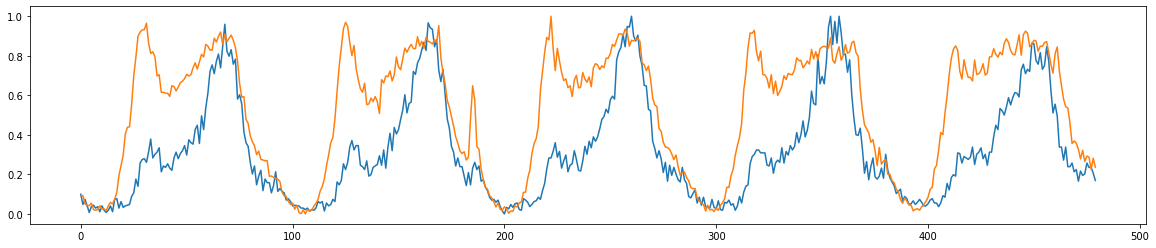

In [4]:
for i in range(Xs.shape[1]):
    plt.figure(figsize=[20,4])
    plt.plot(Xs[:, i])
    plt.plot(Xt[:, i])

## 1.d. Hyperparameters

In [5]:
label_seq_len = 3
# batch_size = full batch
seq_len = 12
reduced_dim = 4
inp_dim = min(Xs.shape[1], Xt.shape[1])
label_dim = min(Xs.shape[1], Xt.shape[1])
hid_dim = 12
layers = 1
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

In [6]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,1,1,3,12,4,12,1,3


## 1.e. Apply BDA and get $Xs_{new}$, $Xt_{new}$ 

In [7]:
# [sample size, seq_len, inp_dim (dets)], [sample size, label_seq_len, inp_dim (dets)]
Xs_3d, Ys_3d = bda_utils.sliding_window(Xs, Xs, seq_len, 1)  
Xt_3d, Yt_3d = bda_utils.sliding_window(Xt, Xt, seq_len, 1)
print(Xs_3d.shape)
print(Ys_3d.shape)
print(Xt_3d.shape)
print(Yt_3d.shape)

(468, 12, 1)
(468, 1, 1)
(468, 12, 1)
(468, 1, 1)


In [8]:
t_s = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xs_train_3d = []
Ys_train_3d = []
Xt_valid_3d = []
Xt_train_3d = []
Yt_valid_3d = []
Yt_train_3d = []

for i in range(Xs_3d.shape[2]):
    print('Starting det %i'%i)
#     bda = BDA(kernel_type='linear', dim=seq_len-reduced_dim, lamb=lamb, mu=0.6, gamma=1, T=1)  # T is iteration time
#     Xs_new, Xt_new, A = bda.fit(
#         Xs_3d[:, :, i], bda_utils.get_class(Ys_3d[:, :, i]), Xt_3d[:, :, i], bda_utils.get_class(Yt_3d[:, :, i])
#     )  # input shape: ns, n_feature | ns, n_label_feature
    Xs_new = Xs_3d[:, :, 0]
    Xt_new = Xt_3d[:, :, 0]
    
    print(Xs_new.shape)
    print(Xt_new.shape)

    day_train_t = 1
    Xs_train = Xs_new.copy()
    Ys_train = Ys_3d[:, :, i]
    Xt_valid = Xt_new.copy()[int(96*day_train_t):, :]
    Xt_train = Xt_new.copy()[:int(96*day_train_t), :]
    Yt_valid = Yt_3d[:, :, i].copy()[int(96*day_train_t):, :]
    Yt_train = Yt_3d[:, :, i].copy()[:int(96*day_train_t), :]
    
    Xs_train_3d.append(Xs_train)
    Ys_train_3d.append(Ys_train)
    Xt_valid_3d.append(Xt_valid)
    Xt_train_3d.append(Xt_train)
    Yt_valid_3d.append(Yt_valid)
    Yt_train_3d.append(Yt_train)


Xs_train_3d = np.array(Xs_train_3d)
Ys_train_3d = np.array(Ys_train_3d)
Xt_valid_3d = np.array(Xt_valid_3d)
Xt_train_3d = np.array(Xt_train_3d)
Yt_valid_3d = np.array(Yt_valid_3d)
Yt_train_3d = np.array(Yt_train_3d)

# bda_utils.save_np(Xs_train_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Ys_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Xt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_valid_3d, './outputs/BDA/Xs_new_%i.csv'%(bda_utils.get_num()-14/6))
# bda_utils.save_np(Yt_train_3d, './outputs/BDA/Xt_new_%i.csv'%(bda_utils.get_num()-14/6))

print('Time spent:%.5f'%(time.time()-t_s))

Starting det 0
(468, 12)
(468, 12)
Time spent:0.03101


In [9]:
Xs_train_3d = np.transpose(Xs_train_3d, (1, 2, 0))
Ys_train_3d = np.transpose(Ys_train_3d, (1, 2, 0))
Xt_valid_3d = np.transpose(Xt_valid_3d, (1, 2, 0))
Xt_train_3d = np.transpose(Xt_train_3d, (1, 2, 0))
Yt_valid_3d = np.transpose(Yt_valid_3d, (1, 2, 0))
Yt_train_3d = np.transpose(Yt_train_3d, (1, 2, 0))

In [10]:
Xs_train_3d.shape

(468, 12, 1)

# 2. Learning Part

## 2.a. Build network

In [11]:
from bda_utils import traff_net_clf

## 2.b. Assemble Dataloader

In [12]:
batch_size = 1960

train_x = Xt_train_3d
train_y = Yt_train_3d

train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
Xt_valid_3d = torch.tensor(Xt_valid_3d, dtype=torch.float32).to(device)
Yt_valid_3d = torch.tensor(Yt_valid_3d, dtype=torch.float32).to(device)

train_dataset = TensorDataset(train_x, train_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)
train_iter = iter(train_loader)

print(train_x.shape)
print(train_y.shape)
print('\n')
print(Xt_valid_3d.shape)
print(Yt_valid_3d.shape)

torch.Size([96, 12, 1])
torch.Size([96, 1, 1])


torch.Size([372, 12, 1])
torch.Size([372, 1, 1])


## 2.c. Learn

In [13]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = traff_net_clf(seq_len).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)
train_loss_set = []
val_loss_set = []

det = 0  # which detector to visualize

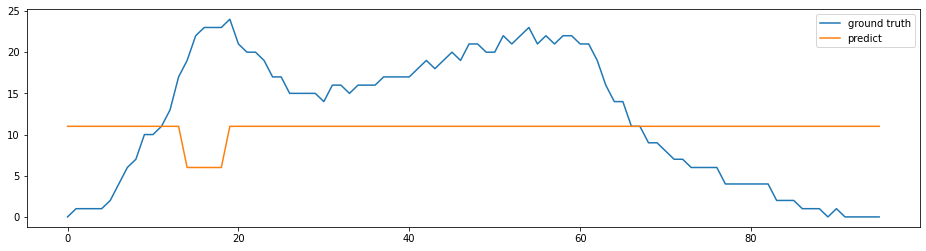

Epoch No. 0 success, loss: 3.25752, val loss: 3.25133, acc: 0.08065


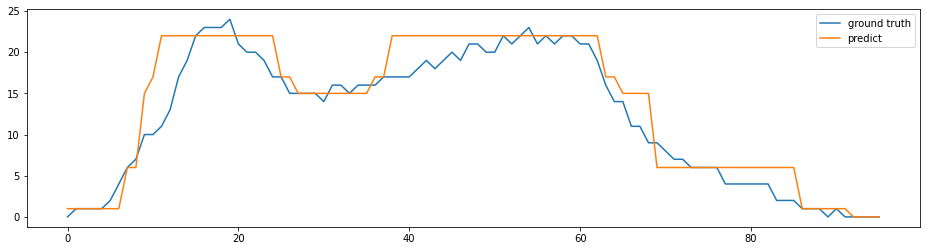

Epoch No. 25 success, loss: 2.62571, val loss: 2.86613, acc: 0.15054


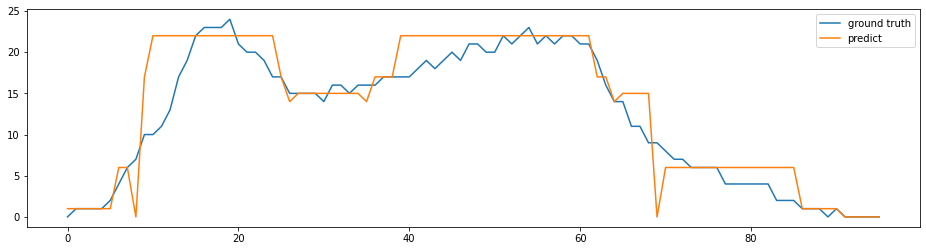

Epoch No. 50 success, loss: 2.40388, val loss: 2.87744, acc: 0.18011


In [14]:
# train
net.train()

epochs = 51

for e in range(epochs):
    for i in range(len(train_loader)):
        try:
            data, label = train_iter.next()
        except:
            train_iter = iter(train_loader)
            data, label = train_iter.next()

        out = net(data)
        loss = criterion(out, bda_utils.get_class(label[:, 0, 0]).flatten().long() )  # label.shape=[batch, 1, num_dets]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        val_out = net(Xt_valid_3d)
        val_loss = criterion(val_out, bda_utils.get_class(Yt_valid_3d[:, 0, 0]).flatten().long() )
        
        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
        
    if e%25*2==0:
#         ipdb.set_trace()
        fig = plt.figure(figsize=[16,4])
        ax1 = fig.add_subplot(111)
        ax1.plot(bda_utils.get_class(label)[:, 0, det].cpu().detach().numpy(), label='ground truth')
        ax1.plot(torch.argmax(out, dim=1).cpu().detach().numpy(), label='predict')
        ax1.legend()
        plt.show()
        print('Epoch No. %i success, loss: %.5f, val loss: %.5f, acc: %.5f'\
              %(e, loss.cpu().detach().numpy(), val_loss.cpu().detach().numpy(), \
               sklearn.metrics.accuracy_score(torch.argmax(val_out, dim=1).cpu(), bda_utils.get_class(Yt_valid_3d[:, 0, det]).cpu().flatten())\
               ))

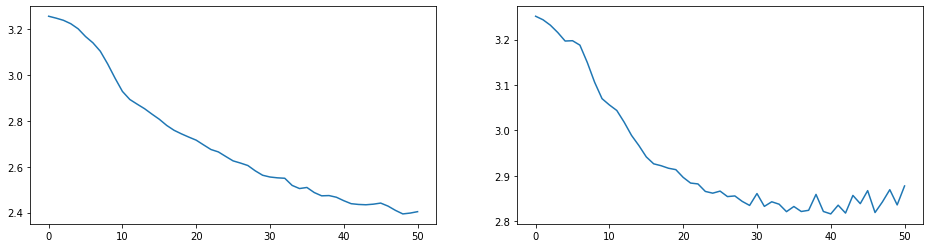

In [15]:
fig = plt.figure(figsize = [16, 4])
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_set)
ax2 = fig.add_subplot(122)
ax2.plot(val_loss_set)

# 3. Evaluation

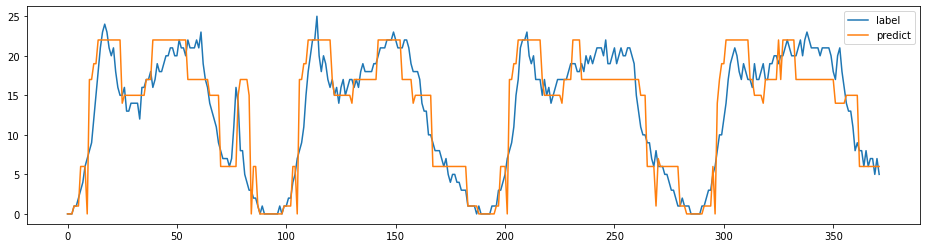

In [16]:
val_out = net(Xt_valid_3d)
plt.figure(figsize=[16,4])
plt.plot(bda_utils.get_class(Yt_valid_3d[:, 0, det]).cpu().flatten(), label='label')
plt.plot(torch.argmax(val_out, dim=1).cpu(), label='predict')
plt.legend()

In [17]:
g_t = torch.argmax(val_out, dim=1).cpu().detach().numpy()
pred = bda_utils.get_class(Yt_valid_3d[:, 0, det]).cpu().flatten().detach().numpy()

print(bda_utils.nrmse_loss_func(g_t, pred, 0))
print(bda_utils.mape_loss_func(g_t, pred, 0))


0.14727169640795906
0.3035619311730471


In [18]:
# torch.save(net.state_dict(), './model/bda_weekday_M1_M4_nrmse=%.5f.pth'%nrmse_loss)